# Read dataset

# Install necessary modules

In [ ]:
!pip install transformers torch

# Prepare pytorch's dataset

In [ ]:
from transformers import AutoTokenizer
import json

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("SpanBERT/spanbert-base-cased")

with open('data.json') as json_file:
    dataset = json.load(json_file)

output = []
for data_point in dataset:
    tokens = data_point['tokens']
    labels = data_point['labels']

    # replace, start, inside, and end with their actual values

    for i, label in enumerate(labels):
        end = label.split("-")
        if len(end) == 2:
            labels[i] = end[1]
        else:
            labels[i] = end[0]

    tokenized_tokens = []
    tokenized_labels = []
    tokenized_attention_mask = []

    for i, token in enumerate(tokens):
        tokenized_token = tokenizer(token.split(), is_split_into_words=True)
        tokenized_label = [labels[i]] * len(tokenized_token["input_ids"])

        tokenized_tokens.extend(tokenized_token["input_ids"])
        tokenized_labels.extend(tokenized_label)
        tokenized_attention_mask.extend(tokenized_token["attention_mask"])

    output.append({"tokens": tokenized_tokens, "labels": tokenized_labels, "attention_mask": tokenized_attention_mask})


def chunk_and_pad(output):
    all_json = []
    for data_point in output:
        tokens = data_point["tokens"]

        labels = data_point["labels"]
        attention_mask = data_point["attention_mask"]

        chunked_tokens = []
        chunked_labels = []
        chunked_attention_mask = []

        for i in range(0, len(tokens), 512):
            chunked_tokens.append(tokens[i:i + 512])
            chunked_labels.append(labels[i:i + 512])
            chunked_attention_mask.append(attention_mask[i:i + 512])

        for i in range(len(chunked_tokens)):
            chunked_tokens[i] = chunked_tokens[i] + [0] * (512 - len(chunked_tokens[i]))
            chunked_labels[i] = chunked_labels[i] + ["O"] * (512 - len(chunked_labels[i]))
            chunked_attention_mask[i] = chunked_attention_mask[i] + [0] * (512 - len(chunked_attention_mask[i]))

        print(len(chunked_tokens[0]))

        for i in range(len(chunked_tokens)):
            all_json.append(
                {"tokens": chunked_tokens[i], "labels": chunked_labels[i], "attention_mask": chunked_attention_mask[i]})

    return all_json


all_json = chunk_and_pad(output)

config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512
512


In [ ]:
print(len(all_json))

143


In [ ]:
from torch import nn
import torch
from torch.utils.data import Dataset


class NERDataset(Dataset):
    def __init__(self, data, tokenizer, label_to_id):
        self.data = data
        self.tokenizer = tokenizer
        self.label_to_id = label_to_id

    def __len__(self):
        return len(self.data)

    def chunk_list(self, lst, chunk_size):
        """Yield successive chunks of size chunk_size from lst."""
        for i in range(0, len(lst), chunk_size):
            yield lst[i:i + chunk_size]

    def __getitem__(self, idx):
        item = self.data[idx]

        # Convert labels to IDs
        label_ids = [self.label_to_id.get(label, 0) for label in item['labels']]
        # Ensure label_ids length matches input_ids length

        return {
            "input_ids": torch.tensor(item["tokens"]),
            "attention_mask": torch.tensor(item["attention_mask"]),
            "labels": torch.LongTensor(label_ids)
        }


label_to_id = {'Requirement': 0, 'Exception': 1, 'Selection': 2,
               'Application': 3}

# Initialize the dataset
ner_dataset = NERDataset(all_json, tokenizer, label_to_id)

In [ ]:
print(ner_dataset[0]["labels"])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Train, Validate and Save best model

In [ ]:
!pip install scikit-learn

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import AutoModelForTokenClassification, AutoTokenizer, AdamW
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


# Parameters
num_labels = len(label_to_id)  # Number of labels in your dataset
model_name = "SpanBERT/spanbert-base-cased"

# Model and Tokenizer Initialization
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset and DataLoader
dataset_size = len(ner_dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation
train_dataset, val_dataset = random_split(ner_dataset, [train_size, val_size])

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Early Stopping
early_stopping_patience = 30
early_stopping_counter = 0
best_loss = float('inf')

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_accuracies = []
train_precisions = []
train_f1s = []
train_recalls = []

val_losses = []
val_accuracies = []
val_precisions = []
val_f1s = []
val_recalls = []

# Training Loop
model.train()
for epoch in range(500):  # Adjust the number of epochs as needed
    total_loss = 0
    all_predictions = []
    all_labels = []

    id_to_label = {v: k for k, v in label_to_id.items()}
    accuracy_per_entity_type = {label: [] for label in id_to_label.values()}

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Convert logits to predictions
        predictions = torch.argmax(logits, dim=2)
        all_predictions.extend(predictions.view(-1).cpu().numpy())
        all_labels.extend(labels.view(-1).cpu().numpy())

        total_loss += loss.item()


    average_loss = total_loss / len(train_loader)

    train_accuracy = accuracy_score(all_labels, all_predictions)
    train_precision = precision_score(all_labels, all_predictions, average='weighted')
    train_recall = recall_score(all_labels, all_predictions, average='weighted')
    train_f1 = f1_score(all_labels, all_predictions, average='weighted')

    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_f1s.append(train_f1)
    train_recalls.append(train_recall)

    print(f"Epoch {epoch+1}: Train: Loss = {average_loss}, Accuracy = {train_accuracy}, Precision = {train_precision}, Recall = {train_recall}, F1 = {train_f1}")

  # Validation
    model.eval()
    total_val_loss = 0
    all_val_predictions = []
    all_val_labels = []
    with torch.no_grad():
        for val_batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}"):
            input_ids = val_batch['input_ids'].to(device)
            attention_mask = val_batch['attention_mask'].to(device)
            labels = val_batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Convert logits to predictions
            val_predictions = torch.argmax(logits, dim=2)
            all_val_predictions.extend(val_predictions.view(-1).cpu().numpy())
            all_val_labels.extend(labels.view(-1).cpu().numpy())

            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = accuracy_score(all_val_labels, all_val_predictions)

    val_precision = precision_score(all_val_labels, all_val_predictions, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_predictions, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')

    val_losses.append(average_val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_f1s.append(val_f1)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch+1}: Validation: Loss = {average_val_loss}, Accuracy = {val_accuracy}, Precision = {val_precision}, Recall = {val_recall}, F1 = {val_f1}")
    # Reduce LR on plateau
    scheduler.step(average_val_loss)

    # Early Stopping
    if average_val_loss < best_loss:
        print(f"Val loss improved from {best_loss} to {average_val_loss}")
        best_loss = average_val_loss
        early_stopping_counter = 0

        torch.save(model.state_dict(), 'best_model_state_dict.pt')
    else:
        print("Val loss did not improve")
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
    print()

pytorch_model.bin:   0%|          | 0.00/215M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1: 100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 1: Train: Loss = 0.9769272843996684, Accuracy = 0.7478241502192983, Precision = 0.6114156022390314, Recall = 0.7478241502192983, F1 = 0.6461507431243034


Validation Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.85it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Validation: Loss = 0.7915014624595642, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss improved from inf to 0.7915014624595642



Training Epoch 2: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Train: Loss = 0.7633750319480896, Accuracy = 0.7535978618421053, Precision = 0.5679097373729929, Recall = 0.7535978618421053, F1 = 0.6477080632117327


Validation Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Validation: Loss = 0.7478862404823303, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss improved from 0.7915014624595642 to 0.7478862404823303



Training Epoch 3: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Train: Loss = 0.7376412133375804, Accuracy = 0.7535978618421053, Precision = 0.5679097373729929, Recall = 0.7535978618421053, F1 = 0.6477080632117327


Validation Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Validation: Loss = 0.7379955053329468, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss improved from 0.7478862404823303 to 0.7379955053329468



Training Epoch 4: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Train: Loss = 0.7279649635155996, Accuracy = 0.7535978618421053, Precision = 0.5679097373729929, Recall = 0.7535978618421053, F1 = 0.6477080632117327


Validation Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4: Validation: Loss = 0.7332735955715179, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss improved from 0.7379955053329468 to 0.7332735955715179



Training Epoch 5: 100%|██████████| 15/15 [00:10<00:00,  1.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Train: Loss = 0.7167819122473399, Accuracy = 0.7535978618421053, Precision = 0.5679097373729929, Recall = 0.7535978618421053, F1 = 0.6477080632117327


Validation Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5: Validation: Loss = 0.7300056219100952, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss improved from 0.7332735955715179 to 0.7300056219100952



Training Epoch 6: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Train: Loss = 0.6946520805358887, Accuracy = 0.7535978618421053, Precision = 0.5679097373729929, Recall = 0.7535978618421053, F1 = 0.6477080632117327


Validation Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  4.58it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6: Validation: Loss = 0.7341107726097107, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss did not improve



Training Epoch 7: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Train: Loss = 0.6818730552991231, Accuracy = 0.7576925712719298, Precision = 0.7189751443242387, Recall = 0.7576925712719298, F1 = 0.6592738132815257


Validation Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 7: Validation: Loss = 0.7300959825515747, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss did not improve



Training Epoch 8: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Train: Loss = 0.6411112030347188, Accuracy = 0.7712102521929824, Precision = 0.6949210503577025, Recall = 0.7712102521929824, F1 = 0.7014019164883839


Validation Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 8: Validation: Loss = 0.7994720935821533, Accuracy = 0.7019127155172413, Precision = 0.6837498786746581, Recall = 0.7019127155172413, F1 = 0.6904889187567244
Val loss did not improve



Training Epoch 9: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9: Train: Loss = 0.637609992424647, Accuracy = 0.7758018092105263, Precision = 0.7049637751909019, Recall = 0.7758018092105263, F1 = 0.7244689455895016


Validation Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  4.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 9: Validation: Loss = 0.8871480077505112, Accuracy = 0.5756330818965517, Precision = 0.6587685145634639, Recall = 0.5756330818965517, F1 = 0.5980497431179388
Val loss did not improve



Training Epoch 10: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10: Train: Loss = 0.6216702004273732, Accuracy = 0.7789542214912281, Precision = 0.7089597372669793, Recall = 0.7789542214912281, F1 = 0.7365211963874515


Validation Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  4.35it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 10: Validation: Loss = 0.8152648061513901, Accuracy = 0.6270878232758621, Precision = 0.6739677970249724, Recall = 0.6270878232758621, F1 = 0.6398071176552439
Val loss did not improve



Training Epoch 11: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11: Train: Loss = 0.6813553929328918, Accuracy = 0.739514802631579, Precision = 0.6711563608759518, Recall = 0.739514802631579, F1 = 0.7012007370730151


Validation Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 11: Validation: Loss = 0.715218260884285, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss improved from 0.7300056219100952 to 0.715218260884285



Training Epoch 12: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12: Train: Loss = 0.63682568470637, Accuracy = 0.7607935855263158, Precision = 0.6587591726487096, Recall = 0.7607935855263158, F1 = 0.6707487675507704


Validation Epoch 12: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12: Validation: Loss = 0.7218987569212914, Accuracy = 0.7685883620689655, Precision = 0.5907280703078552, Recall = 0.7685883620689655, F1 = 0.6680221163694618
Val loss did not improve



Training Epoch 13: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13: Train: Loss = 0.5761321385701498, Accuracy = 0.7943564967105263, Precision = 0.7676556042101755, Recall = 0.7943564967105263, F1 = 0.7511877760602622


Validation Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 13: Validation: Loss = 0.7246921062469482, Accuracy = 0.7644127155172413, Precision = 0.6637425472482579, Recall = 0.7644127155172413, F1 = 0.6906156963369902
Val loss did not improve



Training Epoch 14: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14: Train: Loss = 0.5536299069722493, Accuracy = 0.8068290844298246, Precision = 0.7808201974198478, Recall = 0.8068290844298246, F1 = 0.7818044587764121


Validation Epoch 14: 100%|██████████| 4/4 [00:00<00:00,  4.45it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14: Validation: Loss = 0.7519777789711952, Accuracy = 0.7110721982758621, Precision = 0.6683692744753714, Recall = 0.7110721982758621, F1 = 0.6889600571734162
Val loss did not improve



Training Epoch 15: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15: Train: Loss = 0.5309023479620616, Accuracy = 0.8158751370614035, Precision = 0.7969783600653525, Recall = 0.8158751370614035, F1 = 0.7994089643425194


Validation Epoch 15: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 15: Validation: Loss = 0.7411558330059052, Accuracy = 0.7516837284482759, Precision = 0.680628074335256, Recall = 0.7516837284482759, F1 = 0.7128398615597744
Val loss did not improve



Training Epoch 16: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16: Train: Loss = 0.5141004641850789, Accuracy = 0.8284847861842105, Precision = 0.8147028085369389, Recall = 0.8284847861842105, F1 = 0.8164362052376477


Validation Epoch 16: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 16: Validation: Loss = 0.7644369229674339, Accuracy = 0.7423895474137931, Precision = 0.6473938537901561, Recall = 0.7423895474137931, F1 = 0.6870820306971368
Val loss did not improve



Training Epoch 17: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17: Train: Loss = 0.5372840126355489, Accuracy = 0.8149671052631579, Precision = 0.8015585355565609, Recall = 0.8149671052631579, F1 = 0.8016307143328347


Validation Epoch 17: 100%|██████████| 4/4 [00:00<00:00,  4.53it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17: Validation: Loss = 0.7251947298645973, Accuracy = 0.763671875, Precision = 0.6755732622597436, Recall = 0.763671875, F1 = 0.7098650060892008
Val loss did not improve



Training Epoch 18: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18: Train: Loss = 0.5258731265862783, Accuracy = 0.8158237390350878, Precision = 0.7920346796846841, Recall = 0.8158237390350878, F1 = 0.7849345317334655


Validation Epoch 18: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 18: Validation: Loss = 0.8131493479013443, Accuracy = 0.6951778017241379, Precision = 0.6854109082025681, Recall = 0.6951778017241379, F1 = 0.6874372610604381
Val loss did not improve



Training Epoch 19: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19: Train: Loss = 0.505785079797109, Accuracy = 0.8295641447368421, Precision = 0.8086014789531903, Recall = 0.8295641447368421, F1 = 0.8140533788668958


Validation Epoch 19: 100%|██████████| 4/4 [00:00<00:00,  4.37it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19: Validation: Loss = 0.8139551877975464, Accuracy = 0.6761179956896551, Precision = 0.6791149329598812, Recall = 0.6761179956896551, F1 = 0.6735068105715892
Val loss did not improve



Training Epoch 20: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20: Train: Loss = 0.5121264199415843, Accuracy = 0.8267715186403509, Precision = 0.80927468342427, Recall = 0.8267715186403509, F1 = 0.8112646340892512


Validation Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  4.41it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20: Validation: Loss = 0.7585185393691063, Accuracy = 0.7666352370689655, Precision = 0.6844866474939596, Recall = 0.7666352370689655, F1 = 0.7173330673606754
Val loss did not improve



Training Epoch 21: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21: Train: Loss = 0.49771578311920167, Accuracy = 0.8263432017543859, Precision = 0.8122840497384398, Recall = 0.8263432017543859, F1 = 0.8126701296624481


Validation Epoch 21: 100%|██████████| 4/4 [00:00<00:00,  4.38it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 21: Validation: Loss = 0.7203190550208092, Accuracy = 0.7138335129310345, Precision = 0.6731750153617565, Recall = 0.7138335129310345, F1 = 0.6927490704342802
Val loss did not improve



Training Epoch 22: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22: Train: Loss = 0.4848771075407664, Accuracy = 0.8448807565789473, Precision = 0.8235929573186132, Recall = 0.8448807565789473, F1 = 0.8256856164083458


Validation Epoch 22: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 22: Validation: Loss = 0.7724601030349731, Accuracy = 0.7161907327586207, Precision = 0.6715564219973547, Recall = 0.7161907327586207, F1 = 0.6931095531593134
Val loss did not improve



Training Epoch 23: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23: Train: Loss = 0.4507836977640788, Accuracy = 0.8530016447368421, Precision = 0.8509923151934138, Recall = 0.8530016447368421, F1 = 0.8379618316294385


Validation Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  4.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 23: Validation: Loss = 0.770358107984066, Accuracy = 0.7308728448275862, Precision = 0.668240882764952, Recall = 0.7308728448275862, F1 = 0.6977291958328189
Val loss did not improve



Training Epoch 24: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24: Train: Loss = 0.44110398093859354, Accuracy = 0.8559998629385965, Precision = 0.8516207099375306, Recall = 0.8559998629385965, F1 = 0.838987474719349


Validation Epoch 24: 100%|██████████| 4/4 [00:00<00:00,  4.55it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 24: Validation: Loss = 0.7780609056353569, Accuracy = 0.7349137931034483, Precision = 0.6681294303183961, Recall = 0.7349137931034483, F1 = 0.6989737535163776
Val loss did not improve



Training Epoch 25: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25: Train: Loss = 0.4357045263051987, Accuracy = 0.860437225877193, Precision = 0.8519401167974306, Recall = 0.860437225877193, F1 = 0.8450552316155182


Validation Epoch 25: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 25: Validation: Loss = 0.7806402444839478, Accuracy = 0.7353178879310345, Precision = 0.6682864268013887, Recall = 0.7353178879310345, F1 = 0.6992053881262581
Val loss did not improve



Training Epoch 26: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26: Train: Loss = 0.4312900871038437, Accuracy = 0.8627672697368421, Precision = 0.8554310918533828, Recall = 0.8627672697368421, F1 = 0.8479585563966834


Validation Epoch 26: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 26: Validation: Loss = 0.7822506278753281, Accuracy = 0.734375, Precision = 0.6680209754180502, Recall = 0.734375, F1 = 0.6986995939247718
Val loss did not improve



Training Epoch 27: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27: Train: Loss = 0.4274094969034195, Accuracy = 0.8679242050438597, Precision = 0.8604554427779846, Recall = 0.8679242050438597, F1 = 0.8546581460912618


Validation Epoch 27: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 27: Validation: Loss = 0.7855527400970459, Accuracy = 0.7338362068965517, Precision = 0.667826768952104, Recall = 0.7338362068965517, F1 = 0.6983658305108534
Val loss did not improve



Training Epoch 28: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28: Train: Loss = 0.4237112214167913, Accuracy = 0.8712650767543859, Precision = 0.863724878292882, Recall = 0.8712650767543859, F1 = 0.8594515386209766


Validation Epoch 28: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 28: Validation: Loss = 0.7890653312206268, Accuracy = 0.732489224137931, Precision = 0.6669383791632302, Recall = 0.732489224137931, F1 = 0.6973257003109432
Val loss did not improve



Training Epoch 29: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29: Train: Loss = 0.4200486222902934, Accuracy = 0.8730297423245614, Precision = 0.8656285480991044, Recall = 0.8730297423245614, F1 = 0.861487963030807


Validation Epoch 29: 100%|██████████| 4/4 [00:00<00:00,  4.43it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 29: Validation: Loss = 0.7922184839844704, Accuracy = 0.7311422413793104, Precision = 0.6663076654787567, Recall = 0.7311422413793104, F1 = 0.69642870561991
Val loss did not improve



Training Epoch 30: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30: Train: Loss = 0.41652608116467793, Accuracy = 0.8743489583333334, Precision = 0.8668373076990691, Recall = 0.8743489583333334, F1 = 0.86295485505642


Validation Epoch 30: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 30: Validation: Loss = 0.7953157722949982, Accuracy = 0.7297279094827587, Precision = 0.6652370601484062, Recall = 0.7297279094827587, F1 = 0.6952478792573047
Val loss did not improve



Training Epoch 31: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31: Train: Loss = 0.4129602243502935, Accuracy = 0.8755996436403509, Precision = 0.8684273980281096, Recall = 0.8755996436403509, F1 = 0.8645024915069475


Validation Epoch 31: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 31: Validation: Loss = 0.7986299842596054, Accuracy = 0.7297279094827587, Precision = 0.6652359626428924, Recall = 0.7297279094827587, F1 = 0.6952410543677715
Val loss did not improve



Training Epoch 32: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32: Train: Loss = 0.40939386586348214, Accuracy = 0.8773300438596491, Precision = 0.8702405822311264, Recall = 0.8773300438596491, F1 = 0.86658459875615


Validation Epoch 32: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 32: Validation: Loss = 0.801780454814434, Accuracy = 0.7286503232758621, Precision = 0.6642813010199834, Recall = 0.7286503232758621, F1 = 0.6942595232390261
Val loss did not improve



Training Epoch 33: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33: Train: Loss = 0.40583573083082836, Accuracy = 0.8788891173245614, Precision = 0.8718688290392084, Recall = 0.8788891173245614, F1 = 0.8684772590429086


Validation Epoch 33: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 33: Validation: Loss = 0.8051480129361153, Accuracy = 0.7278421336206896, Precision = 0.6634873506916767, Recall = 0.7278421336206896, F1 = 0.6934540750524306
Val loss did not improve



Training Epoch 34: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34: Train: Loss = 0.40313254396120707, Accuracy = 0.8802939967105263, Precision = 0.8732717924784471, Recall = 0.8802939967105263, F1 = 0.8701936382544023


Validation Epoch 34: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 34: Validation: Loss = 0.8053803592920303, Accuracy = 0.7278421336206896, Precision = 0.6634187477570991, Recall = 0.7278421336206896, F1 = 0.6934111368101871
Val loss did not improve



Training Epoch 35: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35: Train: Loss = 0.402776383360227, Accuracy = 0.8803796600877193, Precision = 0.8734205804991086, Recall = 0.8803796600877193, F1 = 0.8702718440806032


Validation Epoch 35: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 35: Validation: Loss = 0.8055775836110115, Accuracy = 0.7278421336206896, Precision = 0.6634187477570991, Recall = 0.7278421336206896, F1 = 0.6934111368101871
Val loss did not improve



Training Epoch 36: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36: Train: Loss = 0.402417916059494, Accuracy = 0.8804310581140351, Precision = 0.8734654117847397, Recall = 0.8804310581140351, F1 = 0.8703112658679055


Validation Epoch 36: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 36: Validation: Loss = 0.8057994320988655, Accuracy = 0.7278421336206896, Precision = 0.6634187477570991, Recall = 0.7278421336206896, F1 = 0.6934111368101871
Val loss did not improve



Training Epoch 37: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37: Train: Loss = 0.4020589679479599, Accuracy = 0.8805338541666666, Precision = 0.8735887472239713, Recall = 0.8805338541666666, F1 = 0.8704195150326587


Validation Epoch 37: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37: Validation: Loss = 0.8060517981648445, Accuracy = 0.7277747844827587, Precision = 0.6633148931072212, Recall = 0.7277747844827587, F1 = 0.6933215247581681
Val loss did not improve



Training Epoch 38: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38: Train: Loss = 0.4016985019048055, Accuracy = 0.8807565789473685, Precision = 0.8738894236823699, Recall = 0.8807565789473685, F1 = 0.8706523857338107


Validation Epoch 38: 100%|██████████| 4/4 [00:00<00:00,  4.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 38: Validation: Loss = 0.8063259422779083, Accuracy = 0.7276400862068966, Precision = 0.6631758251344012, Recall = 0.7276400862068966, F1 = 0.6931852755585136
Val loss did not improve



Training Epoch 39: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39: Train: Loss = 0.40133585731188454, Accuracy = 0.8808422423245614, Precision = 0.873994321537536, Recall = 0.8808422423245614, F1 = 0.8707587843751564


Validation Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 39: Validation: Loss = 0.8066133707761765, Accuracy = 0.7276400862068966, Precision = 0.6631070448785914, Recall = 0.7276400862068966, F1 = 0.6931422231427267
Val loss did not improve



Training Epoch 40: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40: Train: Loss = 0.4009708275397619, Accuracy = 0.880945038377193, Precision = 0.8740989476741747, Recall = 0.880945038377193, F1 = 0.8708792859229922


Validation Epoch 40: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 40: Validation: Loss = 0.8069077357649803, Accuracy = 0.7275053879310345, Precision = 0.6629679099596394, Recall = 0.7275053879310345, F1 = 0.6930059467364832
Val loss did not improve



Training Epoch 41: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41: Train: Loss = 0.40060331920782727, Accuracy = 0.8811334978070176, Precision = 0.8742441949123737, Recall = 0.8811334978070176, F1 = 0.8710810239872679


Validation Epoch 41: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 41: Validation: Loss = 0.8072054386138916, Accuracy = 0.7274380387931034, Precision = 0.6629327893205194, Recall = 0.7274380387931034, F1 = 0.6929593612769686
Val loss did not improve
Early stopping triggered


In [ ]:
!pip install matplotlib

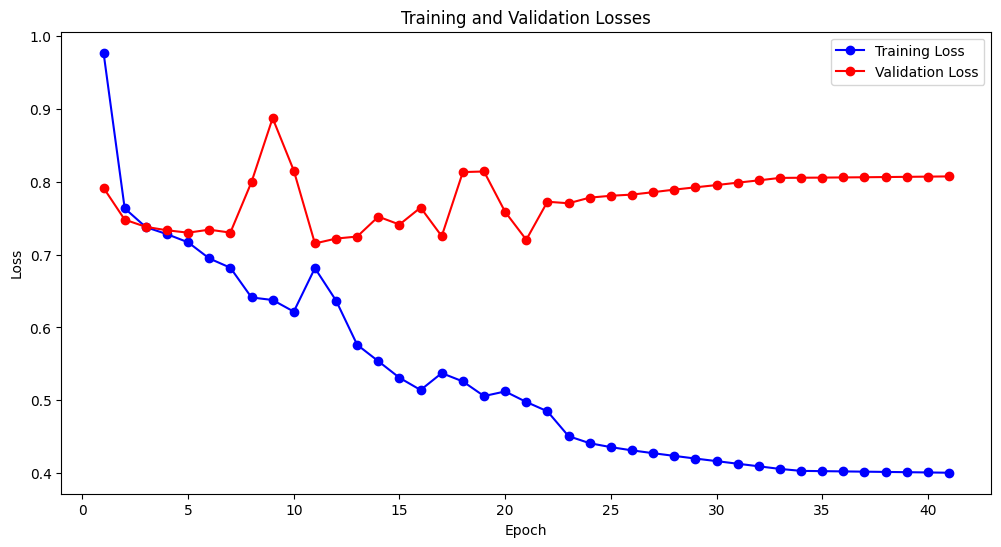

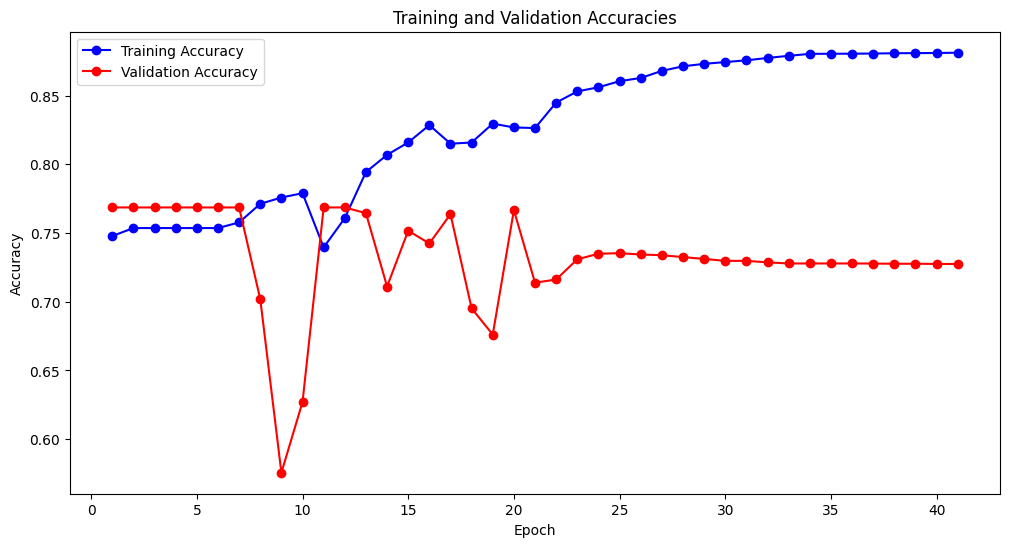

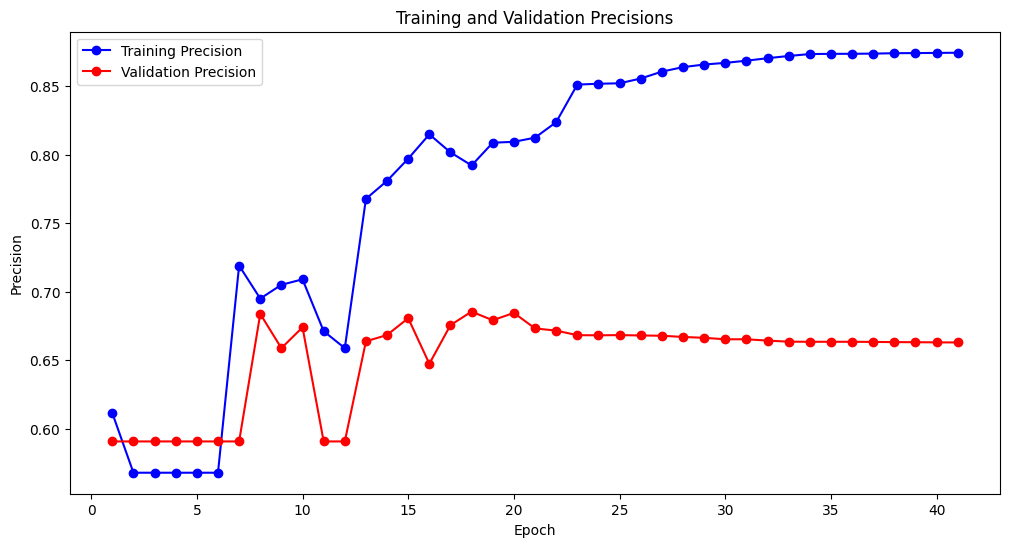

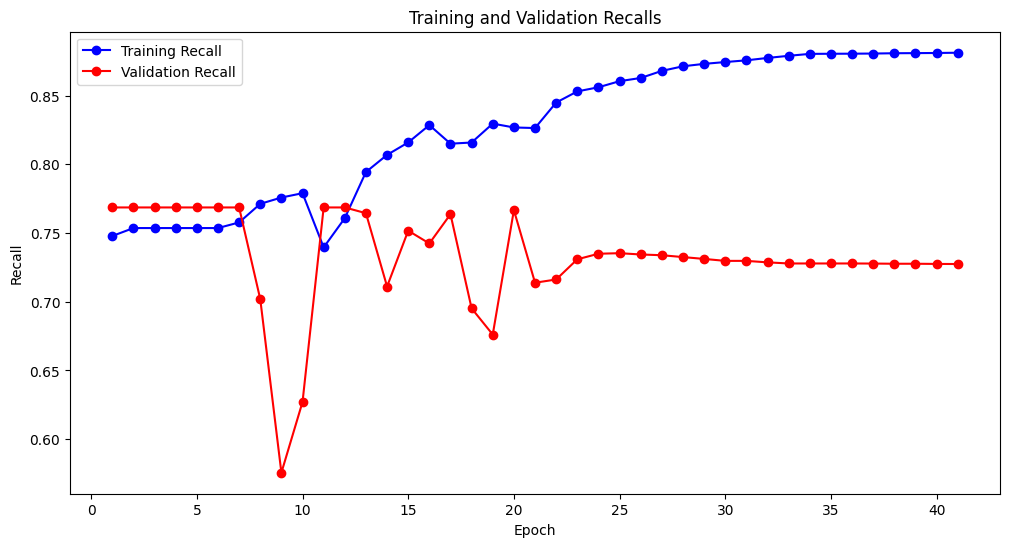

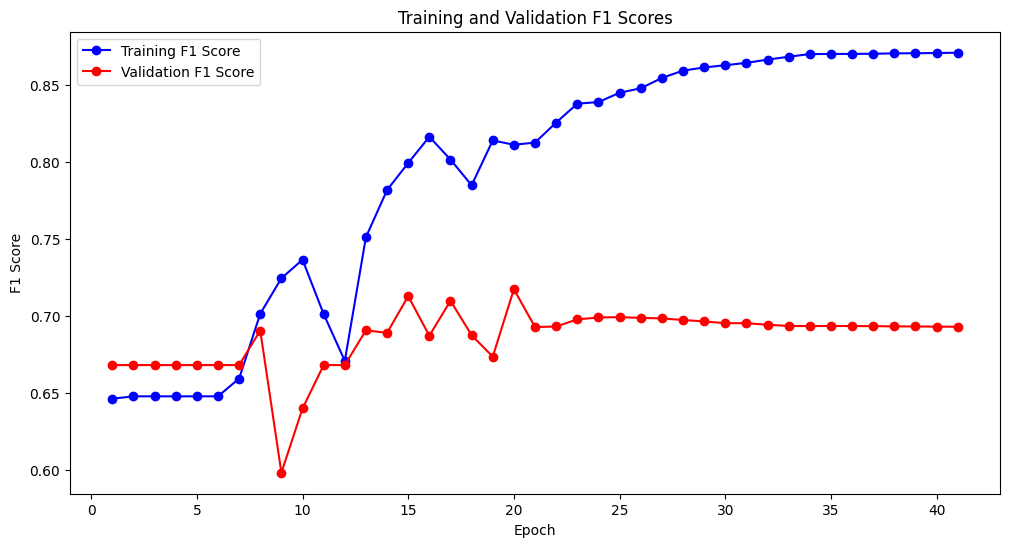

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

def ploty(title, title_plural, train_values, val_values, epochs):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_values, 'bo-', label=f'Training {title}')
    plt.plot(epochs, val_values, 'ro-', label=f'Validation {title}')
    plt.title(f'Training and Validation {title_plural}')
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()
    plt.show()

# Plotting training and validation losses
ploty(
    title="Loss",
    title_plural = "Losses",
    train_values = train_losses,
    val_values = val_losses,
    epochs = epochs
)


ploty(
    title="Accuracy",
    title_plural = "Accuracies",
    train_values = train_accuracies,
    val_values = val_accuracies,
    epochs = epochs
)


ploty(
    title="Precision",
    title_plural = "Precisions",
    train_values = train_precisions,
    val_values = val_precisions,
    epochs = epochs
)

ploty(
    title="Recall",
    title_plural = "Recalls",
    train_values = train_recalls,
    val_values = val_recalls,
    epochs = epochs
)

ploty(
    title="F1 Score",
    title_plural = "F1 Scores",
    train_values = train_f1s,
    val_values = val_f1s,
    epochs = epochs
)

# Test the model

In [ ]:
import torch
from transformers import AutoTokenizer
import torch.nn.functional as F

# Load the trained model and tokenizer
model_name = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

id_to_label = {v: k for k, v in label_to_id.items()}


# Function to test the model on new text
def test_model(text):
    # Tokenize the input text
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)

    model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=9)
    state_dict = torch.load('best_model_state_dict.pt')
    model.load_state_dict(state_dict)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Move tensors to the same device as the model
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)

    # Model inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Apply softmax to the model output to get probabilities
    predictions = F.softmax(outputs.logits, dim=-1)

    # Get the most likely class for each token
    predicted_indices = torch.argmax(predictions, dim=-1)
    predicted_indices = predicted_indices.cpu().numpy()

    # Convert predicted indices to class names
    # Assuming you have a dictionary `id_to_label` mapping label IDs to label names
    predicted_labels = [[id_to_label[idx] for idx in indices] for indices in predicted_indices]

    return predicted_labels

# Example usage
text = "Regarding the performance of wall linings, a wall includes: the internal surface of internal and external glazing (except glazing in doors)any part of a ceiling that slopes at an angle greater than 70o to the horizontalHowever"
predicted_labels = test_model(text)  # Assuming test_model returns token-level labels

# Tokenize the text
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
input_ids = inputs["input_ids"][0]

# Decode each token ID and pair it with its predicted label
decoded_tokens_with_labels = []
for idx, token_id in enumerate(input_ids):
    token = tokenizer.decode(token_id, skip_special_tokens=False)
    if token not in tokenizer.all_special_tokens:
        # Get the label for the token
        label = predicted_labels[0][idx] if idx < len(predicted_labels[0]) else 'O'
        if str(label).strip() == "O":
          label = ""
        else:
          label = f" ({label})"
        decoded_tokens_with_labels.append(f"{token}{label}")

# Create the formatted string
formatted_text = ' '.join(decoded_tokens_with_labels)
print(formatted_text)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: ignored

In [ ]:
# Example usage
text = "Regarding the performance of wall linings, a wall includes: the internal surface of internal and external glazing (except glazing in doors)any part of a ceiling that slopes at an angle greater than 70o to the horizontalHowever"
predicted_labels = test_model(text)  # Assuming test_model returns token-level labels

# Tokenize the text
inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
input_ids = inputs["input_ids"][0]